In [41]:
from src.data_structures import Instance
from src.solvers.OG.model import CustomSolver,Net
from src.solvers.OG.integer_quantizer import KmeansQuantizer
import numpy as np
import torch
from matplotlib import pyplot as plt
from functools import partial
import torch.nn as nn
import torch.optim as optim
import sys
torch.set_default_tensor_type(torch.DoubleTensor)


In [42]:
instance = Instance.generate_quadratic(25,20)

In [43]:
solver = CustomSolver(instance=instance)

In [44]:
benefit_data = solver.benefit_data
quantizer = KmeansQuantizer(benefit_data,10)
solver.set_integer_quantizer(quantizer)

running k-means on cpu..


[running kmeans]: 4it [00:00, 868.12it/s, center_shift=0.000000, iteration=4, tol=0.000100]


In [45]:


x = solver.create_vectorized_data()
x


tensor([[1., 0., 1.,  ..., 0., 0., 0.],
        [1., 1., 0.,  ..., 0., 0., 0.],
        [0., 1., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.],
        [0., 0., 0.,  ..., 0., 1., 0.]])

In [46]:
y = solver.quantizer.indexes().view(-1,1)
#Normalizo y 
y_size = torch.max(y)+1

def tupla_a_vector_binario(tupla,size):
    output = np.zeros(size)
    for i in tupla:
        output[i] = 1
    return output

y = torch.tensor(np.array(list(map(partial(tupla_a_vector_binario,size=y_size),y)),dtype=np.float64))





En base a la definicion anterior estoy intendando predecir el indice y, en base a la tupla polinomial vectorizada x

In [47]:
#Intentar adivinar el indice

net = Net(solver.instance.n_items,y_size)
criterion = nn.SmoothL1Loss()
optimizer = optim.SGD(net.parameters(),lr = 1)

dataset = torch.utils.data.TensorDataset(x,y)
dataloader = torch.utils.data.DataLoader(dataset,batch_size=3,shuffle=True)

In [58]:
for epoch in range(1000):
    total_loss = 0
    for batch_x, batch_y in dataloader:
        optimizer.zero_grad()
        batch_output = net(batch_x)
        batch_loss = criterion(batch_output, batch_y)
        batch_loss.backward()
        optimizer.step()
        total_loss += batch_loss.item()
    
    sys.stdout.write(f'\rEpoch {epoch}, Loss {total_loss / len(dataloader)}')
    sys.stdout.flush()

Epoch 99, Loss 0.0041068506422508416

0.02212796


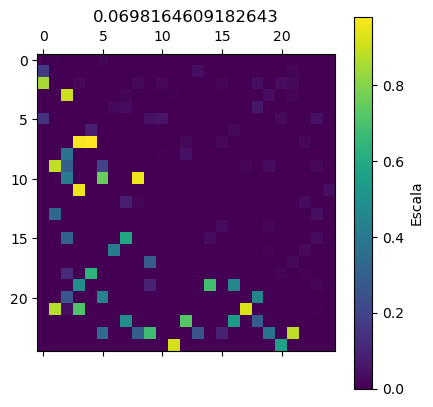

In [59]:
matrix = np.zeros((instance.n_items,instance.n_items))
stats = []

for point,value in instance.syn_dict.items():
    matrix[point[1],point[0]] = value
    vectorized_point = solver.tupla_a_vector_binario(point)
    vectorized_point = torch.tensor(vectorized_point).view(1,-1)
    vectorized_r_index = net(vectorized_point)
    r_index = torch.argmax(vectorized_r_index)
    r_value = solver.quantizer.cluster_centers[r_index]
    stats.append(abs(value-r_value))
    matrix[point[0],point[1]] = abs(value-r_value)

print(np.average(stats))
plt.matshow(matrix)
plt.colorbar(label="Escala")
plt.title(f"{total_loss}")
plt.savefig("difference.png")
